In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from init_objects import *
from functions.stylizedfacts import *
from functions.helpers import organise_data
from functions.inequality import gini, lorenz_curve
from qe_inequality_model import *
import statsmodels.api as sm
from matplotlib import style
import scipy.stats as stats
#from statsmodels.iolib.summary2 import summary_col
from functions.find_bubbles import *

In [5]:
style.use('seaborn-ticks')

In [6]:
def confidence_interval(data, av):
    sample_stdev = np.std(data)
    sigma = sample_stdev/math.sqrt(len(data))
    return stats.t.interval(alpha = 0.95, df= 24, loc=av, scale=sigma) 

# How QE interacts with Asset Price Cycles

In [27]:
NRUNS = 5
burn_in_period = 0

In [28]:
params = {"fundamental_values": [105, 166], "asset_types": ['stock', 'stock'],
              "trader_sample_size": 22, "n_traders": 500,
              "ticks": 1552, "std_fundamentals": [0.02, 0.053],
              "std_noise": 0.159, "w_random": 0.056,
              "strat_share_chartists": 0.305,
              "init_assets": [1662, 571], "base_risk_aversion": 4.051,
              'spread_max': 0.004, "horizon": 200,
              "fundamentalist_horizon_multiplier": 2.22,
              "trades_per_tick": 3, "mutation_intensity": 0.477,
              "average_learning_ability": 0.38, 'money_multiplier': 0.7,
              "bond_mean_reversion": 0.0,
              "qe_perc_size": 0.0, "qe_start": 1, "qe_end": 2, "qe_asset_index": 0}

In [29]:
trdrs = []
orbs = []
central_banks = []

for seed in range(NRUNS): 
    traders, central_bank, orderbook = init_objects_qe_ineq(params, seed)
    traders, central_bank, orderbook = qe_ineq_model(traders, central_bank, orderbook, params, seed)
    central_banks.append(central_bank)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
4

499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748


802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
104

1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283


1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525


In [30]:
asset_prices = []
asset_fundamentals = []
asset_volumes = []

for idx, a in enumerate(params['asset_types']):
    ap = pd.DataFrame([orbs[run][idx].tick_close_price for run in range(NRUNS)]).transpose()
    asset_prices.append(ap)
    
    fn = pd.DataFrame([orbs[run][idx].fundamental for run in range(NRUNS)]).transpose()
    asset_fundamentals.append(fn)
    
    av = pd.DataFrame([[sum(v) for v in orbs[run][idx].transaction_volumes_history] for run in range(NRUNS)]).transpose()
    asset_volumes.append(av)

### Plot model dynamics & identify boom-bust periods 

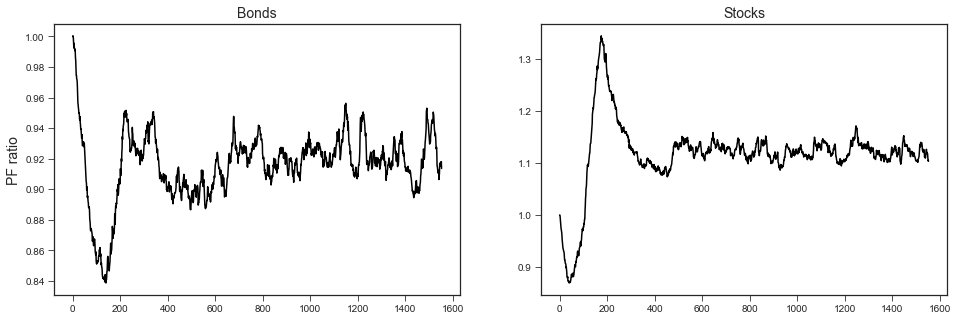

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

ax1.set_title('Bonds', fontsize='14')
ax2.set_title('Stocks', fontsize='14')

ax1.plot(asset_prices[0].index, (asset_prices[0].mean(axis=1) / asset_fundamentals[0].mean(axis=1))[:], 'k-', label='pf')
ax1.set_ylabel('PF ratio', fontsize='14')
ax2.plot(asset_prices[1].index, asset_prices[1].mean(axis=1) / asset_fundamentals[1].mean(axis=1), 'k-', label='pf')


#fig.savefig('non_QE_dynamics.png', dpi=200)

# QE in the steady state

In [40]:
params["qe_perc_size"] = 0.16
params["qe_start"] = 600
params["qe_end"] = 900

In [41]:
NRUNS = 5

In [42]:
trdrs_qe = []
orbs_qe = []
central_banks_qe = []

for seed in range(NRUNS): 
    traders_qe, central_bank_qe, orderbook_qe = init_objects_qe_ineq(params, seed)
    traders_qe, central_bank_qe, orderbook_qe = qe_ineq_model(traders_qe, central_bank_qe, orderbook_qe, params, seed)
    central_banks_qe.append(central_bank_qe)
    trdrs_qe.append(traders_qe)
    orbs_qe.append(orderbook_qe)

Start of simulation  0
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
4

498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747


801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040

1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283


1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525


In [43]:
asset_prices_qe = []
asset_fundamentals_qe = []
asset_volumes_qe = []

for idx, a in enumerate(params['asset_types']):
    ap_qe = pd.DataFrame([orbs_qe[run][idx].tick_close_price for run in range(NRUNS)]).transpose()
    asset_prices_qe.append(ap_qe)
    
    fn_qe = pd.DataFrame([orbs_qe[run][idx].fundamental for run in range(NRUNS)]).transpose()
    asset_fundamentals_qe.append(fn_qe)
    
    av_qe = pd.DataFrame([[sum(v) for v in orbs_qe[run][idx].transaction_volumes_history] for run in range(NRUNS)]).transpose()
    asset_volumes_qe.append(av)

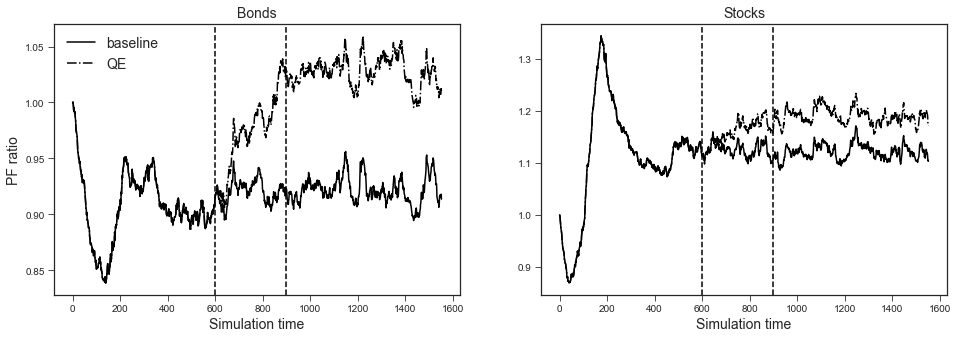

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

ax1.set_title('Bonds', fontsize='14')
ax2.set_title('Stocks', fontsize='14')

ax1.plot(asset_prices[0].index, (asset_prices[0].mean(axis=1) / asset_fundamentals[0].mean(axis=1))[:], 'k-', label='baseline')
ax1.plot(asset_prices_qe[0].index, (asset_prices_qe[0].mean(axis=1) / asset_fundamentals_qe[0].mean(axis=1))[:], 'k-.', label='QE')
ax1.set_ylabel('PF ratio', fontsize='14')
ax1.legend(loc='best', fontsize='14')

ax2.plot(asset_prices[1].index, asset_prices[1].mean(axis=1) / asset_fundamentals[1].mean(axis=1), 'k-', label='baseline')
ax2.plot(asset_prices_qe[1].index, asset_prices_qe[1].mean(axis=1) / asset_fundamentals_qe[1].mean(axis=1), 'k-.', label='QE')

for ax in [ax1, ax2]:
    ax.axvline(params["qe_start"], color='k', linestyle='--')
    ax.axvline(params["qe_end"], color='k', linestyle='--')
    ax.set_xlabel('Simulation time', fontsize='14')

fig.savefig('QE_steady_state.png', dpi=200)

# QE effect on prices & volatility

# STOP HERE

In [140]:
params["qe_perc_size"] = 0.60
params["qe_start"] = 1
params["qe_end"] = 320
params["ticks"] = 400

In [141]:
NRUNS = 1

In [142]:
trdrs = []
orbs = []
central_banks = []

for seed in range(NRUNS): 
    params["qe_start"] = bust_time_starts[seed]
    traders, central_bank, orderbook = init_objects_qe_ineq(params, seed)
    traders, central_bank, orderbook = qe_ineq_model(traders, central_bank, orderbook, params, seed)
    central_banks.append(central_bank)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
4

In [143]:
asset_prices = []
asset_fundamentals = []
asset_volumes = []

for idx, a in enumerate(params['asset_types']):
    ap = pd.DataFrame([orbs[run][idx].tick_close_price for run in range(NRUNS)]).transpose()
    asset_prices.append(ap)
    
    fn = pd.DataFrame([orbs[run][idx].fundamental for run in range(NRUNS)]).transpose()
    asset_fundamentals.append(fn)
    
    av = pd.DataFrame([[sum(v) for v in orbs[run][idx].transaction_volumes_history] for run in range(NRUNS)]).transpose()
    asset_volumes.append(av)

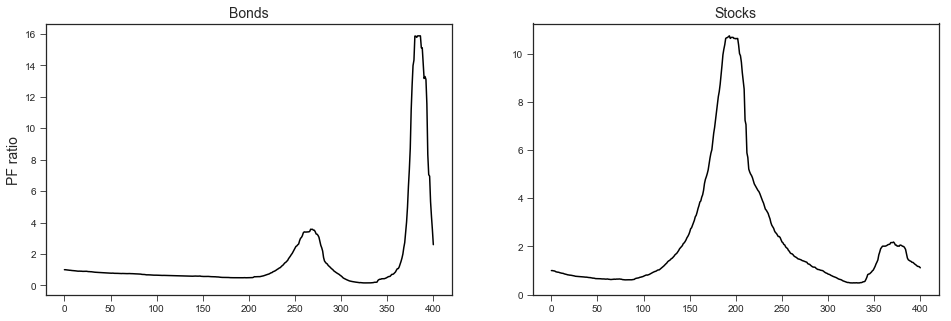

In [144]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

ax1.set_title('Bonds', fontsize='14')
ax2.set_title('Stocks', fontsize='14')

ax1.plot(asset_prices[0].index, asset_prices[0].mean(axis=1) / asset_fundamentals[0].mean(axis=1), 'k-', label='pf')
ax1.set_ylabel('PF ratio', fontsize='14')
ax2.plot(asset_prices[1].index, asset_prices[1].mean(axis=1) / asset_fundamentals[1].mean(axis=1), 'k-', label='pf')

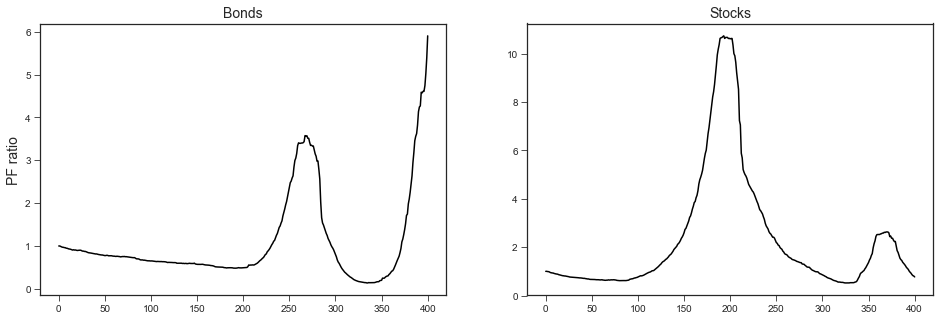

In [128]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

ax1.set_title('Bonds', fontsize='14')
ax2.set_title('Stocks', fontsize='14')

ax1.plot(asset_prices[0].index, asset_prices[0].mean(axis=1) / asset_fundamentals[0].mean(axis=1), 'k-', label='pf')
ax1.set_ylabel('PF ratio', fontsize='14')
ax2.plot(asset_prices[1].index, asset_prices[1].mean(axis=1) / asset_fundamentals[1].mean(axis=1), 'k-', label='pf')

# ax3.bar(range(len(asset_volumes[0].mean(axis=1))), asset_volumes[0].mean(axis=1), color='black')
# ax4.bar(range(len(asset_volumes[1].mean(axis=1))), asset_volumes[1].mean(axis=1), color='black')
# ax3.set_ylabel('Volume', fontsize='14')

#fig.savefig('QE_dynamics.png', dpi=200)

In [39]:
# experiment. QE effect on lowest & highest point 

In [40]:
steps = 16
qe_size = [x / 100.0 for x in range(0, 100 + steps, steps)]
#qe_size = qe_size[:2] #TODO remove? 
qe_size = qe_size[:-4]
qe_size

[0.0, 0.16, 0.32, 0.48]

In [51]:
qt_qe_size = [-x for x in qe_size[::-1]] + qe_size
qt_qe_size

[-0.48, -0.32, -0.16, -0.0, 0.0, 0.16, 0.32, 0.48]

In [42]:
experiments = len(qt_qe_size)

In [43]:
full_qe_size = []
for exp in range(experiments):
    for seed in range(NRUNS):
        full_qe_size.append(qt_qe_size[exp])

In [44]:
trdrs = []
orbs = []
central_banks = []

for exp in range(experiments):
    params['qe_perc_size'] = qt_qe_size[exp]
    for seed in range(NRUNS): 
        traders, central_bank, orderbook = init_objects_qe_ineq(params, seed)
        traders, central_bank, orderbook = qe_ineq_model(traders, central_bank, orderbook, params, seed)
        central_banks.append(central_bank)
        trdrs.append(traders)
        orbs.append(orderbook)

Start of simulation  0
201
202
203
204
205
206
207
208
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
209
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
210
211
212
213
214
215
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
216
217
218
219
220
221
222
223
224
225
226
227
CB is technically creating assets to do QT
228
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
229
2

321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
Start of simulation  1
201
202
203
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
204
CB is technically creating assets to do QT
CB is technically creating assets to do QT
205
206
207
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating 

321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
Start of simulation  2
201
202
203
204
205
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
206
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
207
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating 

329
330
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
331
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
332
333
334
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
335
336
337
338
339
CB is technically creating assets to do QT
340
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is 

325
CB is technically creating assets to do QT
CB is technically creating assets to do QT
326
327
328
329
330
331
332
333
334
335
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
336
CB is technically creating assets to do QT
CB is technically creating assets to do QT
337
338
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
Start of simulation  4
201
202
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically cr

312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
Start of simulation  0
201
202
203
204
205
206
207
208
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
209
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
210
211
212
213
214
215
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB

235
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
236
237
238
239
240
241
242
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
243
244
245
CB is technically creating assets to do QT
CB is technically creating assets to do QT
246
247
248
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
249
250
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
251
252
253
254
255
256
257
258
259
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do 

265
266
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
267
268
269
270
271
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
272
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
273
274
275
276
277
278
279
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to 

323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
Start of simulation  4
201
202
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
203
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
204
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
205
CB is technically creating assets to do QT
206
CB is technically creating assets to do QT
CB is technically creating assets to do QT
207
208
CB is technically creating assets to do QT
CB is technically creating asse

253
254
255
256
257
258
259
260
261
262
263
264
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
265
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
266
267
268
269
270
271
272
273
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
274
CB is technically creating assets to do QT
CB is tec

223
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
224
225
CB is technically creating assets to do QT
CB is technically creating assets to do QT
226
CB is technically creating assets to do QT
227
228
229
230
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
231
232
CB is technically creating assets to do QT
CB is technically creating assets to do QT
233
CB is technically creating assets to do QT
234
CB is technically creating assets to do QT
235
CB is technically creating assets to do QT
236
CB is technically creating assets to do QT
237
238
239
240
241
242
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
243
CB is technically creating assets to do QT
244
245
246
247
CB is technically creating assets to do 

CB is technically creating assets to do QT
CB is technically creating assets to do QT
207
CB is technically creating assets to do QT
208
CB is technically creating assets to do QT
CB is technically creating assets to do QT
209
CB is technically creating assets to do QT
CB is technically creating assets to do QT
210
CB is technically creating assets to do QT
211
CB is technically creating assets to do QT
212
CB is technically creating assets to do QT
213
CB is technically creating assets to do QT
214
CB is technically creating assets to do QT
CB is technically creating assets to do QT
215
CB is technically creating assets to do QT
216
CB is technically creating assets to do QT
217
218
219
CB is technically creating assets to do QT
CB is technically creating assets to do QT
220
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
221
CB is technically creating assets to 

345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
Start of simulation  0
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
3

337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
Start of simulation  0
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
3

329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400


In [45]:
asset_prices = []
asset_fundamentals = []
asset_volumes = []

for idx, a in enumerate(params['asset_types']):
    ap = pd.DataFrame([orbs[run][idx].tick_close_price for run in range(NRUNS * experiments)]).transpose()
    asset_prices.append(ap)
    
    fn = pd.DataFrame([orbs[run][idx].fundamental for run in range(NRUNS * experiments)]).transpose()
    asset_fundamentals.append(fn)
    
    av = pd.DataFrame([[sum(v) for v in orbs[run][idx].transaction_volumes_history] for run in range(NRUNS * experiments)]).transpose()
    asset_volumes.append(av)

## Compare extremes

In [46]:
av_p0_experiments = []
av_p1_experiments = []

av_fn0_experiments = []
av_fn1_experiments = []

av_vol0_experiments = []
av_vol1_experiments = []

for x in range(experiments):
    y = x*NRUNS
    
    #prices
    p0 = asset_prices[0][list(range(y,y+NRUNS))]
    av_p0_experiments.append(p0.mean(axis=1))
    
    p1 = asset_prices[-1][list(range(y,y+NRUNS))]
    av_p1_experiments.append(p1.mean(axis=1))
    
    # fundamentals
    f0 = asset_fundamentals[0][list(range(y,y+NRUNS))]
    av_fn0_experiments.append(f0.mean(axis=1))
    
    f1 = asset_fundamentals[-1][list(range(y,y+NRUNS))]
    av_fn1_experiments.append(f1.mean(axis=1))
    
    # volumes
    v0 = asset_volumes[0][list(range(y,y+NRUNS))]
    av_vol0_experiments.append(v0.mean(axis=1))
    
    v1 = asset_volumes[-1][list(range(y,y+NRUNS))]
    av_vol1_experiments.append(v1.mean(axis=1))

In [58]:
qt_qe_size[0]

-0.48

Text(0, 0.5, 'Volume')

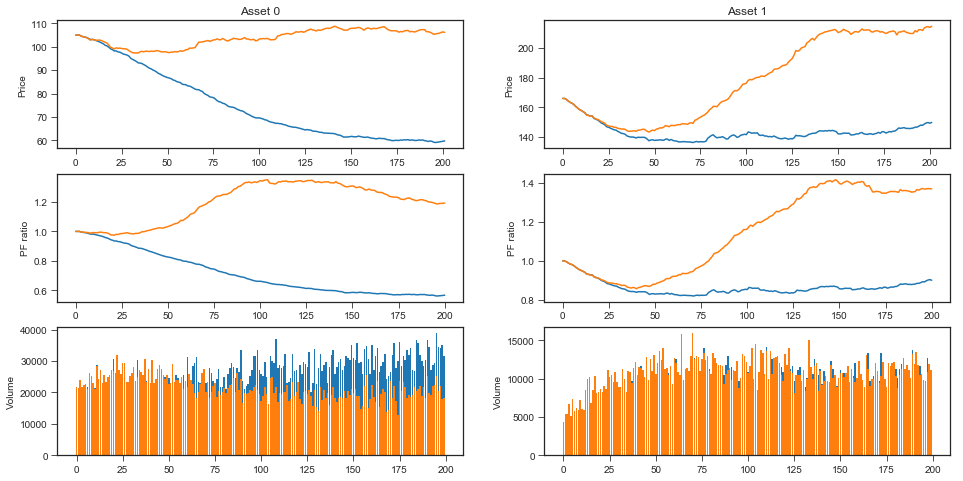

In [57]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16,8))

# prices
ax1.set_title('Asset 0')
ax1.plot(av_p0_experiments[0].index, av_p0_experiments[0], label='no-qe')
ax1.plot(av_p0_experiments[-3].index, av_p0_experiments[-3], label='qe')
ax1.set_ylabel('Price')

ax2.set_title('Asset 1')
ax2.plot(av_p1_experiments[0].index, av_p1_experiments[0], label='no-qe')
ax2.plot(av_p1_experiments[-3].index, av_p1_experiments[-3], label='qe')
ax2.set_ylabel('Price')

# pf ratio's 
ax3.plot(av_p0_experiments[0].index, av_p0_experiments[0] / av_fn0_experiments[0])
ax3.plot(av_p0_experiments[-2].index, av_p0_experiments[-2] / av_fn0_experiments[-2])
ax3.set_ylabel('PF ratio')

ax4.plot(av_p1_experiments[0].index, av_p1_experiments[0] / av_fn1_experiments[0])
ax4.plot(av_p1_experiments[-2].index, av_p1_experiments[-2] / av_fn1_experiments[-2])
ax4.set_ylabel('PF ratio')

# volumes
ax5.bar(av_vol0_experiments[0].index, av_vol0_experiments[0])
ax5.bar(av_vol0_experiments[-2].index, av_vol0_experiments[-2])
ax5.set_ylabel('Volume')

ax6.bar(av_vol1_experiments[0].index, av_vol1_experiments[0])
ax6.bar(av_vol1_experiments[-2].index, av_vol1_experiments[-2])
ax6.set_ylabel('Volume')



In [48]:
# split the data in parts of 10 
p0_averages = []
p0_conf_interval_uppers = []
p0_conf_intervals_lowers = []

p1_averages = []
p1_conf_interval_uppers = []
p1_conf_intervals_lowers = []

pf0_averages = []
pf0_conf_interval_uppers = []
pf0_conf_intervals_lowers = []

pf1_averages = []
pf1_conf_interval_uppers = []
pf1_conf_intervals_lowers = []

p0_stdev = []
p0_stdev_conf_interval_uppers = []
p0_stdev_conf_intervals_lowers = []

p1_stdev = []
p1_stdev_conf_interval_uppers = []
p1_stdev_conf_intervals_lowers = []


for x in range(experiments):
    y = x*NRUNS
    p0 = asset_prices[0][list(range(y,y+NRUNS))]
    p1 = asset_prices[-1][list(range(y,y+NRUNS))]
    f0 = asset_fundamentals[0][list(range(y,y+NRUNS))]
    f1 = asset_fundamentals[-1][list(range(y,y+NRUNS))]
    
    pf0 = np.mean(p0 / f0)
    pf1 = np.mean(p1 / f1)
    
    p0stdev = np.std(p0)
    p1stdev = np.std(p1)
    
    p0 = np.mean(p0)
    p1 = np.mean(p1)
    
    # p0
    p0_averages.append(np.mean(p0))
    sample_stdev = np.std(p0)
    sigma = sample_stdev/math.sqrt(len(p0))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(p0), scale = sigma) 
    p0_conf_interval_uppers.append(upper)
    p0_conf_intervals_lowers.append(lower)
    
    # p1
    p1_averages.append(np.mean(p1))
    sample_stdev = np.std(p1)
    sigma = sample_stdev/math.sqrt(len(p1))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(p1), scale = sigma) 
    p1_conf_interval_uppers.append(upper)
    p1_conf_intervals_lowers.append(lower)
    
    # pf0
    pf0_averages.append(np.mean(pf0))
    sample_stdev = np.std(pf0)
    sigma = sample_stdev/math.sqrt(len(pf0))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(pf0), scale = sigma) 
    pf0_conf_interval_uppers.append(upper)
    pf0_conf_intervals_lowers.append(lower)
    
    # pf1
    pf1_averages.append(np.mean(pf1))
    sample_stdev = np.std(pf1)
    sigma = sample_stdev/math.sqrt(len(pf1))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(pf1), scale = sigma) 
    pf1_conf_interval_uppers.append(upper)
    pf1_conf_intervals_lowers.append(lower)
    
    #p0 stdev ADD rolling stdev
    p0_stdev.append(np.mean(p0stdev))
    sample_stdev = np.std(p0stdev)
    sigma = sample_stdev/math.sqrt(len(p0stdev))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(p0stdev), scale = sigma) 
    p0_stdev_conf_interval_uppers.append(upper)
    p0_stdev_conf_intervals_lowers.append(lower)
    
    #p1 stdev
    p1_stdev.append(np.mean(p1stdev))
    sample_stdev = np.std(p1stdev)
    sigma = sample_stdev/math.sqrt(len(p1stdev))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(p1stdev), scale = sigma) 
    p1_stdev_conf_interval_uppers.append(upper)
    p1_stdev_conf_intervals_lowers.append(lower)
    

In [49]:
data = pd.DataFrame({'lin_size_qe': qt_qe_size})
data['const'] = 1

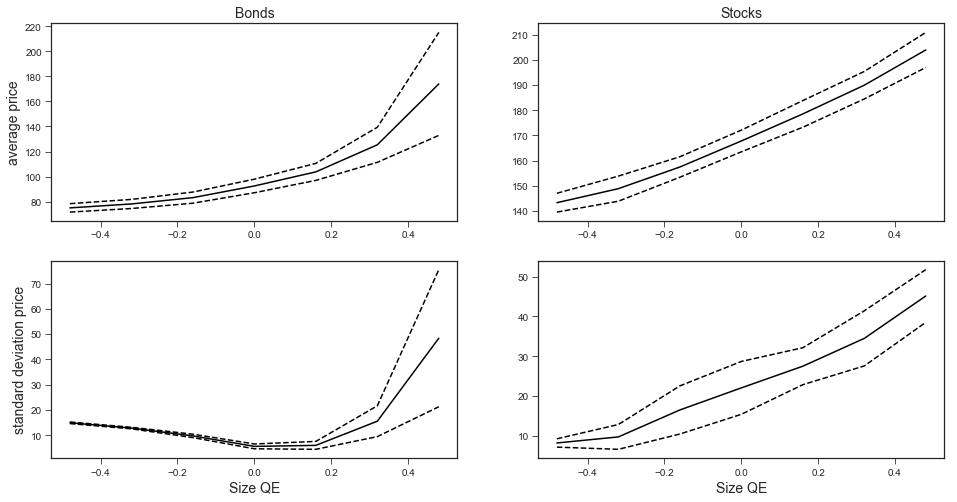

In [53]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=[16,8])

ax1.set_title('Bonds', fontsize='14')
ax2.set_title('Stocks', fontsize='14')

ax1.plot(data['lin_size_qe'], p0_averages, 'k')
ax1.plot(data['lin_size_qe'], p0_conf_interval_uppers, 'k--')
ax1.plot(data['lin_size_qe'], p0_conf_intervals_lowers, 'k--')
ax1.set_ylabel('average price', fontsize='14')

ax2.plot(data['lin_size_qe'], p1_averages, 'k')
ax2.plot(data['lin_size_qe'], p1_conf_interval_uppers, 'k--')
ax2.plot(data['lin_size_qe'], p1_conf_intervals_lowers, 'k--')
#ax2.set_ylabel('price to fundamentals ratio 2', fontsize='14')

ax3.plot(data['lin_size_qe'], p0_stdev, 'k')
ax3.plot(data['lin_size_qe'], p0_stdev_conf_interval_uppers, 'k--')
ax3.plot(data['lin_size_qe'], p0_stdev_conf_intervals_lowers, 'k--')
ax3.set_ylabel('standard deviation price', fontsize='14')

ax4.plot(data['lin_size_qe'], p1_stdev, 'k')
ax4.plot(data['lin_size_qe'], p1_stdev_conf_interval_uppers, 'k--')
ax4.plot(data['lin_size_qe'], p1_stdev_conf_intervals_lowers, 'k--')
#ax4.set_ylabel('$\sigma^{p}$', fontsize='14')

for ax in [ax3, ax4]:
    ax.set_xlabel('Size QE', fontsize='14')
    
fig.savefig('QE_QT_in_bust.png', dpi=200)

# QE in a boom

In [72]:
params["qe_start"] = 101
params["qe_end"] = 190
params["ticks"] = 300

In [73]:
trdrs = []
orbs = []
central_banks = []

for exp in range(experiments):
    params['qe_perc_size'] = qt_qe_size[exp]
    for seed in range(NRUNS): 
        traders, central_bank, orderbook = init_objects_qe_ineq(params, seed)
        traders, central_bank, orderbook = qe_ineq_model(traders, central_bank, orderbook, params, seed)
        central_banks.append(central_bank)
        trdrs.append(traders)
        orbs.append(orderbook)

Start of simulation  0
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
303
CB is technically creating assets to do QT
304
CB is technically creating assets to do QT
305
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
306
307
308
CB is technically creating assets to do QT
CB is technically creating assets to do QT
309
CB is technically creatin

381
382
383
384
385
386
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
387
388
CB is technically creating assets to do QT
389
390
391
392
393
394
395
396
397
398
399
400
401
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
402
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is tec

361
362
CB is technically creating assets to do QT
CB is technically creating assets to do QT
363
364
365
366
367
368
369
370
371
372
373
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
374
375
376
377
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
378
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
379
380
381
382
383
384
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
385
386
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to

CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
367
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
368
369
370
371
372
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
373
CB is technically creating assets to do QT
CB is technically creating assets to do QT
374
375
376
377
378
379
380
381
382
383
384
385
386
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
CB is technically creating assets t

CB is technically creating assets to do QT
361
362
363
364
365
CB is technically creating assets to do QT
366
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
384
385
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do 

CB is technically creating assets to do QT
CB is technically creating assets to do QT
364
365
366
367
368
369
370
371
372
373
374
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
375
376
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
377
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
378
379
380
CB is technically creating assets to do QT
CB is technically creating as

359
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
360
CB is technically creating assets to do QT
361
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
362
CB is technically creating assets to do QT
CB is technically creating assets to do QT
363
CB is technically creating assets to do QT
364
CB is technically creating assets to do QT
365
CB is technically creating assets to do QT
366
CB is technically creating assets to do QT
CB is technically creating assets to do QT
367
368
369
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
370
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
371
CB

356
357
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
358
CB is technically creating assets to do QT
359
CB is technically creating assets to do QT
CB is technically creating assets to do QT
360
CB is technically creating assets to do QT
361
CB is technically creating assets to do QT
CB is technically creating assets to do QT
362
CB is technically creating assets to do QT
363
364
CB is technically creating assets to do QT
CB is technically creating assets to do QT
365
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
366
367
368
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
369
370
371
CB is technically creating assets

369
370
371
372
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
373
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
374
375
376
377
378
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
379
380
381
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
382
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
383
384
385
386
387
388
389
390
391
392
3

CB is technically creating assets to do QT
386
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
387
CB is technically creating assets to do QT
CB is technically creating assets to do QT
388
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
389
CB is technically creating assets to do QT
390
CB is technically creating assets to do QT
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
4

394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
Start of simulation  0
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
303
CB is te

CB is technically creating assets to do QT
CB is technically creating assets to do QT
322
CB is technically creating assets to do QT
323
CB is technically creating assets to do QT
324
CB is technically creating assets to do QT
325
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
326
CB is technically creating assets to do QT
327
CB is technically creating assets to do QT
328
CB is technically creating assets to do QT
CB is technically creating assets to do QT
329
CB is technically creating assets to do QT
330
CB is technically creating assets to do QT
331
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
332
CB is technically creating assets to do QT
333
CB is technically creating assets to do QT
CB is technically creating assets to do QT
334
CB

353
CB is technically creating assets to do QT
354
CB is technically creating assets to do QT
CB is technically creating assets to do QT
355
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
356
CB is technically creating assets to do QT
CB is technically creating assets to do QT
357
CB is technically creating assets to do QT
358
CB is technically creating assets to do QT
359
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
360
361
362
363
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
364
CB is technically creating assets to do QT
365
CB is technically creating assets to do QT
CB is technically creating assets to do QT
366
CB is technically creating assets to do QT
CB is technically creating assets to do Q

388
CB is technically creating assets to do QT
389
CB is technically creating assets to do QT
CB is technically creating assets to do QT
390
CB is technically creating assets to do QT
CB is technically creating assets to do QT
CB is technically creating assets to do QT
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
Start of simulation  4
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267

273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
Start of simulation  2
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
2

487
488
489
490
491
492
493
494
495
496
497
498
499
500
Start of simulation  3
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
4

395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
Start of simulation  0
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
3

303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
Start of simulation  2
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
2

In [74]:
asset_prices = []
asset_fundamentals = []
asset_volumes = []

for idx, a in enumerate(params['asset_types']):
    ap = pd.DataFrame([orbs[run][idx].tick_close_price for run in range(NRUNS * experiments)]).transpose()
    asset_prices.append(ap)
    
    fn = pd.DataFrame([orbs[run][idx].fundamental for run in range(NRUNS * experiments)]).transpose()
    asset_fundamentals.append(fn)
    
    av = pd.DataFrame([[sum(v) for v in orbs[run][idx].transaction_volumes_history] for run in range(NRUNS * experiments)]).transpose()
    asset_volumes.append(av)

In [75]:
av_p0_experiments = []
av_p1_experiments = []

av_fn0_experiments = []
av_fn1_experiments = []

av_vol0_experiments = []
av_vol1_experiments = []

for x in range(experiments):
    y = x*NRUNS
    
    #prices
    p0 = asset_prices[0][list(range(y,y+NRUNS))]
    av_p0_experiments.append(p0.mean(axis=1))
    
    p1 = asset_prices[-1][list(range(y,y+NRUNS))]
    av_p1_experiments.append(p1.mean(axis=1))
    
    # fundamentals
    f0 = asset_fundamentals[0][list(range(y,y+NRUNS))]
    av_fn0_experiments.append(f0.mean(axis=1))
    
    f1 = asset_fundamentals[-1][list(range(y,y+NRUNS))]
    av_fn1_experiments.append(f1.mean(axis=1))
    
    # volumes
    v0 = asset_volumes[0][list(range(y,y+NRUNS))]
    av_vol0_experiments.append(v0.mean(axis=1))
    
    v1 = asset_volumes[-1][list(range(y,y+NRUNS))]
    av_vol1_experiments.append(v1.mean(axis=1))

Text(0, 0.5, 'Volume')

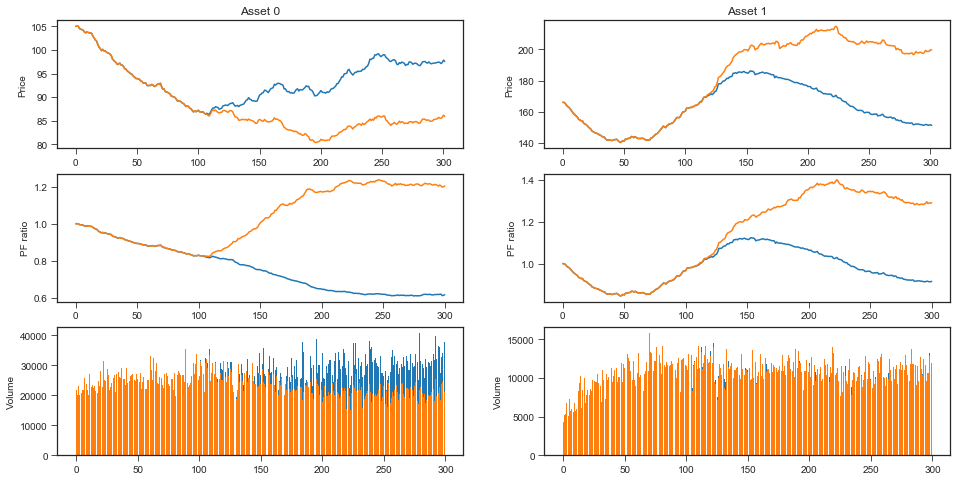

In [82]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16,8))

# prices
ax1.set_title('Asset 0')
ax1.plot(av_p0_experiments[-5].index, av_p0_experiments[-5], label='no-qe')
ax1.plot(av_p0_experiments[-6].index, av_p0_experiments[-6], label='qe')
ax1.set_ylabel('Price')

ax2.set_title('Asset 1')
ax2.plot(av_p1_experiments[0].index, av_p1_experiments[0], label='no-qe')
ax2.plot(av_p1_experiments[-3].index, av_p1_experiments[-3], label='qe')
ax2.set_ylabel('Price')

# pf ratio's 
ax3.plot(av_p0_experiments[0].index, av_p0_experiments[0] / av_fn0_experiments[0])
ax3.plot(av_p0_experiments[-2].index, av_p0_experiments[-2] / av_fn0_experiments[-2])
ax3.set_ylabel('PF ratio')

ax4.plot(av_p1_experiments[0].index, av_p1_experiments[0] / av_fn1_experiments[0])
ax4.plot(av_p1_experiments[-2].index, av_p1_experiments[-2] / av_fn1_experiments[-2])
ax4.set_ylabel('PF ratio')

# volumes
ax5.bar(av_vol0_experiments[0].index, av_vol0_experiments[0])
ax5.bar(av_vol0_experiments[-2].index, av_vol0_experiments[-2])
ax5.set_ylabel('Volume')

ax6.bar(av_vol1_experiments[0].index, av_vol1_experiments[0])
ax6.bar(av_vol1_experiments[-2].index, av_vol1_experiments[-2])
ax6.set_ylabel('Volume')



In [77]:
# split the data in parts of 10 
p0_averages = []
p0_conf_interval_uppers = []
p0_conf_intervals_lowers = []

p1_averages = []
p1_conf_interval_uppers = []
p1_conf_intervals_lowers = []

pf0_averages = []
pf0_conf_interval_uppers = []
pf0_conf_intervals_lowers = []

pf1_averages = []
pf1_conf_interval_uppers = []
pf1_conf_intervals_lowers = []

p0_stdev = []
p0_stdev_conf_interval_uppers = []
p0_stdev_conf_intervals_lowers = []

p1_stdev = []
p1_stdev_conf_interval_uppers = []
p1_stdev_conf_intervals_lowers = []


for x in range(experiments):
    y = x*NRUNS
    p0 = asset_prices[0][list(range(y,y+NRUNS))]
    p1 = asset_prices[-1][list(range(y,y+NRUNS))]
    f0 = asset_fundamentals[0][list(range(y,y+NRUNS))]
    f1 = asset_fundamentals[-1][list(range(y,y+NRUNS))]
    
    pf0 = np.mean(p0 / f0)
    pf1 = np.mean(p1 / f1)
    
    p0stdev = np.std(p0)
    p1stdev = np.std(p1)
    
    p0 = np.mean(p0)
    p1 = np.mean(p1)
    
    # p0
    p0_averages.append(np.mean(p0))
    sample_stdev = np.std(p0)
    sigma = sample_stdev/math.sqrt(len(p0))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(p0), scale = sigma) 
    p0_conf_interval_uppers.append(upper)
    p0_conf_intervals_lowers.append(lower)
    
    # p1
    p1_averages.append(np.mean(p1))
    sample_stdev = np.std(p1)
    sigma = sample_stdev/math.sqrt(len(p1))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(p1), scale = sigma) 
    p1_conf_interval_uppers.append(upper)
    p1_conf_intervals_lowers.append(lower)
    
    # pf0
    pf0_averages.append(np.mean(pf0))
    sample_stdev = np.std(pf0)
    sigma = sample_stdev/math.sqrt(len(pf0))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(pf0), scale = sigma) 
    pf0_conf_interval_uppers.append(upper)
    pf0_conf_intervals_lowers.append(lower)
    
    # pf1
    pf1_averages.append(np.mean(pf1))
    sample_stdev = np.std(pf1)
    sigma = sample_stdev/math.sqrt(len(pf1))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(pf1), scale = sigma) 
    pf1_conf_interval_uppers.append(upper)
    pf1_conf_intervals_lowers.append(lower)
    
    #p0 stdev ADD rolling stdev
    p0_stdev.append(np.mean(p0stdev))
    sample_stdev = np.std(p0stdev)
    sigma = sample_stdev/math.sqrt(len(p0stdev))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(p0stdev), scale = sigma) 
    p0_stdev_conf_interval_uppers.append(upper)
    p0_stdev_conf_intervals_lowers.append(lower)
    
    #p1 stdev
    p1_stdev.append(np.mean(p1stdev))
    sample_stdev = np.std(p1stdev)
    sigma = sample_stdev/math.sqrt(len(p1stdev))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(p1stdev), scale = sigma) 
    p1_stdev_conf_interval_uppers.append(upper)
    p1_stdev_conf_intervals_lowers.append(lower)
    

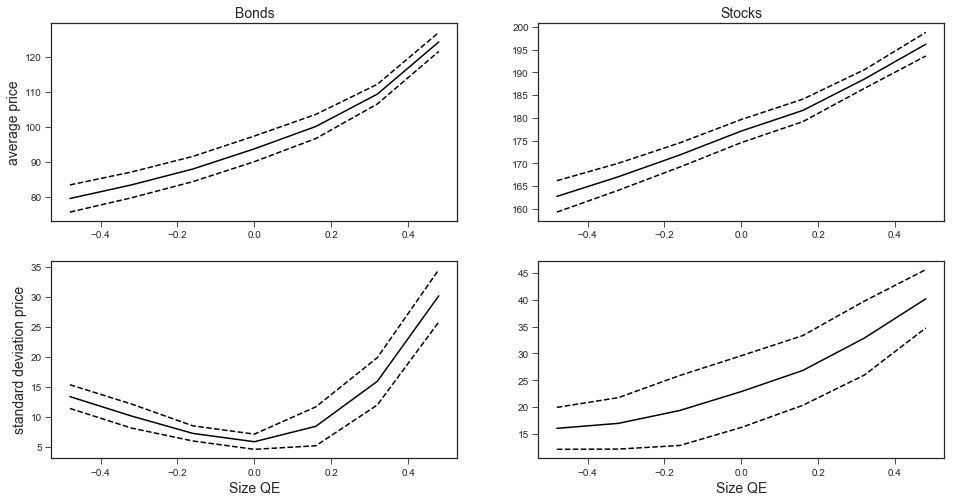

In [78]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=[16,8])

ax1.set_title('Bonds', fontsize='14')
ax2.set_title('Stocks', fontsize='14')

ax1.plot(data['lin_size_qe'], p0_averages, 'k')
ax1.plot(data['lin_size_qe'], p0_conf_interval_uppers, 'k--')
ax1.plot(data['lin_size_qe'], p0_conf_intervals_lowers, 'k--')
ax1.set_ylabel('average price', fontsize='14')

ax2.plot(data['lin_size_qe'], p1_averages, 'k')
ax2.plot(data['lin_size_qe'], p1_conf_interval_uppers, 'k--')
ax2.plot(data['lin_size_qe'], p1_conf_intervals_lowers, 'k--')
#ax2.set_ylabel('price to fundamentals ratio 2', fontsize='14')

ax3.plot(data['lin_size_qe'], p0_stdev, 'k')
ax3.plot(data['lin_size_qe'], p0_stdev_conf_interval_uppers, 'k--')
ax3.plot(data['lin_size_qe'], p0_stdev_conf_intervals_lowers, 'k--')
ax3.set_ylabel('standard deviation price', fontsize='14')

ax4.plot(data['lin_size_qe'], p1_stdev, 'k')
ax4.plot(data['lin_size_qe'], p1_stdev_conf_interval_uppers, 'k--')
ax4.plot(data['lin_size_qe'], p1_stdev_conf_intervals_lowers, 'k--')
#ax4.set_ylabel('$\sigma^{p}$', fontsize='14')

for ax in [ax3, ax4]:
    ax.set_xlabel('Size QE', fontsize='14')
    
fig.savefig('QE_QT_in_boom.png', dpi=200)